<h1>CS4619: Artificial Intelligence II</h1>
<h1>Word Embeddings</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$
$\newcommand{\Tuple}[1]{\langle#1\rangle}$
$\newcommand{\v}[1]{\pmb{#1}}$
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$
$\newcommand{\rv}[1]{[#1]}$
$\DeclareMathOperator{\argmax}{arg\,max}$
$\DeclareMathOperator{\argmin}{arg\,min}$
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from keras import Input
from keras import Model
from keras import Layer
from keras.layers import CategoryEncoding
from keras.layers import Dense
from keras.layers import Reshape

from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping

from keras.layers import TextVectorization
from keras.layers import Embedding

from keras.initializers import Constant

from tensorflow import convert_to_tensor, one_hot, string, tensordot, norm

In [ ]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "."

In [15]:
def cosine(x, xprime):
    return tensordot(x, xprime, 1) / (norm(x) * norm(xprime))

<h1>Acknowledgements</h1>
<ul>
    <li>Part of the code comes from chapter 6 of:
        Fran&ccedil;ois Chollet: <i>Deep Learning with Python</i>,
        Manning Publications, 2018
    </li>
    <li>The analogy between representing words by their word embeddings and representing cities by their co-ordinates comes from: <a href="https://www.theguardian.com/technology/ng-interactive/2023/nov/01/how-ai-chatbots-like-chatgpt-or-bard-work-visual-explainer">this news article</a>.</li>
</ul>

<h1>Natural Language Processing</h1>
<ul>
    <li>In the previous lecture, we represented each document as a single vector (bag-of-words).
        <ul>
            <li>This is OK for some applications, e.g. spam filtering.</li>
            <li>As we saw in the previous lecture, it was OK for sentiment analysis of movie reviews.</li>
        </ul>
    </li>
    <li>But for many applications of natural language processing (NLP), we may need to treat documents as
        <em>sequences</em> (lists) of words (and maybe of punctuation symbols also):
        <ul>
            <li>Perhaps sentiment analysis;</li>
            <li>Machine translation;</li>
            <li>Image captioning;
            </li>
            <li>Question-answering and chatbots.</li>
        </ul>
    </li>
    <li>There are other applications where each example is a sequence of features too, e.g.:
        <ul>
            <li>processing speech;</li>
            <li>processing other audio, such as music;</li>
            <li>processing genomic data;</li>
            <li>timeseries prediction;</li>
            <li>clickstream prediction.</li>
        </ul>
    </li>
</ul>

<h1>Natural Language Processing</h1>
<ul>
    <li>In the previous lecture, we represented each document as a single vector (bag-of-words).
        <ul>
            <li>This is OK for some applications, e.g. spam filtering.</li>
            <li>As we saw in the previous lecture, it was OK for sentiment analysis of movie reviews.</li>
        </ul>
    </li>
    <li>But for many applications of natural language processing (NLP), we may need to treat documents as
        <em>sequences</em> (lists) of words (and maybe of punctuation symbols also):
        <ul>
            <li>Perhaps sentiment analysis;</li>
            <li>Machine translation;</li>
            <li>Image captioning;
            </li>
            <li>Question-answering and chatbots.</li>
        </ul>
    </li>
    <li>There are other applications where each example is a sequence of features too, e.g.:
        <ul>
            <li>processing speech;</li>
            <li>processing other audio, such as music;</li>
            <li>processing genomic data;</li>
            <li>timeseries prediction;</li>
            <li>clickstream prediction.</li>
        </ul>
    </li>
</ul>

<h2>Sequences of integers</h2>
<ul>
    <li>Now, each word will be given a unique integer (an index, e.g. "the" might be word number 2, "a" might be
        word number 3, and so on).
    </li>
    <li>It is common to restrict to a certain vocabulary, e.g. in the code below, we
        restrict to the most common 20000 words (in fact, 19998 words), so the indexes are from 0 to 19999. In real applications, this might be several tens-of-thousands or even 100s-of-thousands of the most common words.
    </li>
    <li>If someone uses words that are not within the vocabulary, then these words are are all treated as a special token UNK and hence are all assigned to the same unique integer (e.g. they are all word number 1).
    </li>
    <li>We also have another special token, called the mask token, with its own index (e.g. 0). Our main use for this is for padding. For example, if we want to treat all documents as having the same length, such as 200 tokens, then we will truncate those that have more than 200 tokens, and we will use the mask token to pad those that have fewer than 200 tokens to bring them up to 200 tokens.
    </li>
    <li>A document will be a sequence of these integers.
    </li>
</ul>

<h2>IMDB Reviews, Again</h2>
<ul>
    <li>Let's read in our small IMDB reviews dataset again and turn it into sequences of integers.</li>
    <li>We use a Keras <code>TextVectorization</code> layer to do the indexing:
        <ul>
            <li>Note, this time, the <code>output_mode</code> is <code>int</code>.</li>
            <li>By default, it converts to lowercase, strips punctuation and splits into tokens at whitespace.</li>
            <li><code>max_tokens</code> restricts the vocabulary to the most common words, and <code>output_sequence_length</code> means reviews will be truncated/padded.
            </li>
            <li>We call <code>adapt</code> on the texts to index the vocabulary. To avoid leakage, this should be done on the training set only.</li>
        </ul>
    </li>
</ul>

In [16]:
df = pd.read_csv(os.path.join(base_dir, "../datasets/dataset_5000_reviews.csv"))

In [17]:
# Train/test split
split_point = int(len(df) * 0.8)
dev_X = convert_to_tensor(df["review"][:split_point])
test_X = convert_to_tensor(df["review"][split_point:])

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["sentiment"])
dev_y = label_encoder.transform(df["sentiment"][:split_point])
test_y = label_encoder.transform(df["sentiment"][split_point:])

In [18]:
max_tokens = 20000
max_length = 200

In [19]:
# Create the count vectorization layer, and call adapt on the text-only dataset to create the vocabulary.
vectorization_layer = TextVectorization(output_mode="int", max_tokens=max_tokens, output_sequence_length=max_length)
vectorization_layer.adapt(dev_X)

In [20]:
vocabulary = vectorization_layer.get_vocabulary()

In [21]:
word_index = dict(zip(vocabulary, range(len(vocabulary))))

In [22]:
# Show you the indexes
word_index

{'': 0,
 '[UNK]': 1,
 np.str_('the'): 2,
 np.str_('a'): 3,
 np.str_('and'): 4,
 np.str_('of'): 5,
 np.str_('to'): 6,
 np.str_('is'): 7,
 np.str_('in'): 8,
 np.str_('i'): 9,
 np.str_('this'): 10,
 np.str_('it'): 11,
 np.str_('that'): 12,
 np.str_('br'): 13,
 np.str_('was'): 14,
 np.str_('as'): 15,
 np.str_('with'): 16,
 np.str_('for'): 17,
 np.str_('movie'): 18,
 np.str_('but'): 19,
 np.str_('film'): 20,
 np.str_('on'): 21,
 np.str_('you'): 22,
 np.str_('not'): 23,
 np.str_('are'): 24,
 np.str_('his'): 25,
 np.str_('have'): 26,
 np.str_('be'): 27,
 np.str_('he'): 28,
 np.str_('one'): 29,
 np.str_('its'): 30,
 np.str_('at'): 31,
 np.str_('all'): 32,
 np.str_('by'): 33,
 np.str_('an'): 34,
 np.str_('they'): 35,
 np.str_('who'): 36,
 np.str_('from'): 37,
 np.str_('so'): 38,
 np.str_('like'): 39,
 np.str_('just'): 40,
 np.str_('or'): 41,
 np.str_('about'): 42,
 np.str_('if'): 43,
 np.str_('her'): 44,
 np.str_('out'): 45,
 np.str_('has'): 46,
 np.str_('there'): 47,
 np.str_('some'): 48,
 np.

In [23]:
# An example movie review
sentence = "This film is as dull as algebra."

In [24]:
# Encode it and show you what it now looks like
encoded_sentence = vectorization_layer(sentence)
encoded_sentence

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([ 10,  20,   7,  15, 668,  15,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

<h1>One-Hot Encoding</h1>
<ul>
    <li>We probably should not use the indexes directly. Why not?</li>
    <li>So we could one-hot encode each word.</li>
</ul>

<h2>IMDB</h2>
<ul>
    <li>In our IMDB example, each review will be transformed from a (length 200) list of ints to a (length 200) list of binary-valued
        vectors (where
        the dimenion of these vectors is 20000. Why?)
    </li>
    <li>Converting from integer indexes to binary vectors can be done in many ways. We will do it using a layer
        in our network using a TensorFlow function.
    </li>
    <li>Then we will flatten the input into a single vector (<code>max_length * max_tokens</code>) and then use
        a few dense layers.
    </li>
</ul>

In [25]:
inputs = Input(shape=(1,), dtype=string)
x = vectorization_layer(inputs)
x = CategoryEncoding(num_tokens=max_tokens, output_mode="one_hot")(x)
x = Reshape((max_tokens * max_length,))(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
one_hot_model = Model(inputs, outputs)

one_hot_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["acc"])

In [26]:
one_hot_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ category_encoding               │ (None, 200, 20000)     │             0 │
│ (CategoryEncoding)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4000000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   256,000,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,002,177 (976.57 MB)

 Trainable params: 256,002,177 (976.57 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
one_hot_history = one_hot_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25,
                                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<Axes: >

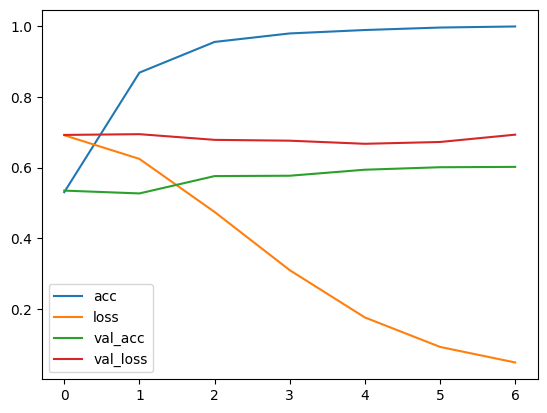

In [28]:
pd.DataFrame(one_hot_history.history).plot()

<ul>
    <li>This network is not very accurate. This is not surprising:
        <ul>
            <li>Small dataset</li>
            <li>One-hot encoding is a poor choice.</li>
        </ul>
    </li>
<ul>

In [29]:
# An illustration of why one-hot encoding is not great.

# Word indexes
print("like: ", word_index["like"] )
print("love: ", word_index["love"] )
print("hate: ", word_index["hate"] )
print("movie: ", word_index["movie"] )
print("film: ", word_index["film"] )

# One hot encodings
one_hot_like = one_hot(word_index["like"], depth=max_tokens)
one_hot_love = one_hot(word_index["love"], depth=max_tokens)
one_hot_hate = one_hot(word_index["hate"], depth=max_tokens)
one_hot_film = one_hot(word_index["film"], depth=max_tokens)
one_hot_movie = one_hot(word_index["movie"], depth=max_tokens)

# Cosine similarities
print("like and love: ", cosine(one_hot_like, one_hot_love))
print("like and hate: ", cosine(one_hot_like, one_hot_hate))
print("movie and film: ", cosine(one_hot_movie, one_hot_film))

like:  39
love:  122
hate:  800
movie:  18
film:  20
like and love:  tf.Tensor(0.0, shape=(), dtype=float32)
like and hate:  tf.Tensor(0.0, shape=(), dtype=float32)
movie and film:  tf.Tensor(0.0, shape=(), dtype=float32)


<h1>Word Embeddings</h1>
<ul>
    <li>One-hot encoding uses large, sparse vectors.</li>
    <li><b>Word embeddings</b> are small, non-sparse vectors, e.g. the dimension might be 100 or 200.</li>
    <li>Analogy: The idea of representing words using vectors (word embeddings) is similar to the way we represent cities as vectors: their co-ordinates (longitude and lattide). For example, the vector for Cork is $\langle -8.5, 51.9\rangle$ (longitude of 8.5 W, lattude of 51.9 N). Cities that are close to each other will have vectors that are close to each other.)
    </li>
    <li>To illustrate the ideas, we will use vectors of size 2 (so we can draw 2D diagrams).</li>
    <li>Perhaps we will have the following word embeddings:
        <img src="images/embeddings.png" style="float: right; margin-left: 5em" />
        <ul>
            <li>Dog: $\langle 0.4, 0.3\rangle$</li>
            <li>Hound: $\langle 0.38, 0.32\rangle$</li>
            <li>Wolf: $\langle 0.4, 0.8\rangle$</li>
            <li>Cat: $\langle 0.75, 0.2\rangle$</li>
            <li>Tiger: $\langle 0.75, 0.7\rangle$</li>
        </ul>
    </li>
    <li>The word embeddings we choose should reflect semantic relationships between the words:
        <ul>
            <li>Words with similar meanings should be close together (as with Dog and Hound) and in general
                the distance between embeddings should reflect how closely related the meanings are.
            </li>
            <li>Geometric transformations might encode semantic relationships, e.g.:
                <ul>
                    <li>Adding $\langle 0, 0.5\rangle$ to the word embedding for Dog gives us the word embedding
                        for Wolf; adding the same vector to the embedding for Cat gives the embedding for Tiger;
                        $\langle 0, 0.5\rangle$ is the "from pet to wild animal" transformation.
                    </li>
                    <li>Similarly $\langle 0.35, -0.1\rangle$ is the "from canine to feline" transformation. Why?
                    </li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<ul>
    <li>There is a Google visiualization here: <a href="https://pair.withgoogle.com/explorables/fill-in-the-blank/">https://pair.withgoogle.com/explorables/fill-in-the-blank/</a></li>
</ul>

<h2>Learning word embeddings</h2>
<ul>
    <li>We learn the word embeddings from the dataset of documents.
    </li>
    <li>Conceptually,
        <ul>
            <li>The values in the vectors are initialized randomly;</li>
            <li>Then they are adjusted during learning.</li>
        </ul>
    </li>
    <li>But Keras does it using a network layer:
        <ul>
            <li>During learning, the weights of the layer are adjusted.</li>
            <li>The activations of the units in the layer are the word embeddings.</li>
        </ul>
    </li>
</ul>

<h2>IMDB</h2>

In [30]:
# Throughout the code, we will use 100-dimensional word embeddings (including the pretrained GloVe embeddings later)
embedding_dimension = 100

In [31]:
inputs = Input(shape=(1,), dtype=string)
x = vectorization_layer(inputs)
x = Embedding(input_dim=max_tokens, output_dim=embedding_dimension)(x)
x = Reshape((embedding_dimension * max_length,))(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
embedding_model = Model(inputs, outputs)

embedding_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["acc"])

In [32]:
embedding_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,177 (12.52 MB)

 Trainable params: 3,282,177 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
embedding_history = embedding_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25,
                                        callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<Axes: >

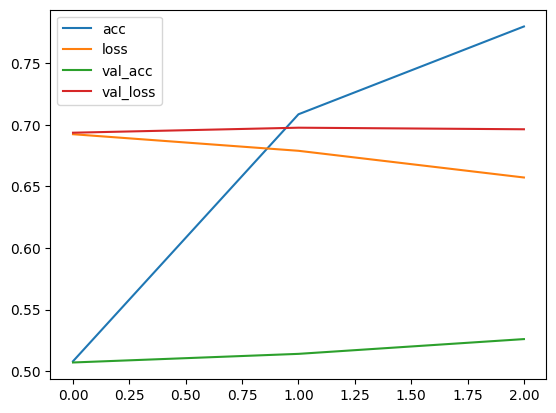

In [34]:
pd.DataFrame(embedding_history.history).plot()

<ul>
    <li>Still not great! Perhaps because so little training data for learning all those embeddings.</li>
</ul>

<h2>Pretrained Word Embeddings</h2>
<ul>
    <li>Above, we got our neural network to learn the word embeddings.
        <ul>
            <li>Advantage: they are based on our IMDB data and therefore tailored to
                helping us to predict the sentiment of movie reviews.
            </li>
            <li>Disadvantage: the IMDB dataset (and especially the subset that we are using) is probably too
                small to learn really powerful
                word embeddings.
            </li>
        </ul>
    </li>
    <li>To some extent, word embeddings are fairly generic, so it can make sense to reuse
        pretrained embeddings from very large datasets, as we did with image data.
        <ul>
            <li><i>word2vec</i> (<a href="https://code.google.com/archive/p/word2vec/">https://code.google.com/archive/p/word2vec/</a>):
                This is Google's famous algorithm for learning word embeddings. The URL contains
                code and also pretrained embeddings learned from news articles.
            </li>
            <li><i>GloVe</i> (Global Vectors for Word Representation,
                <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a>):
                This is a Stanford University algorithm. The URL has code and pretrained
                embeddings learned from Wikipedia.
            </li>
        </ul>
    </li>
    <li>Although we'll use GloVe, let's briefly explain how Google learns its <i>word2vec</i> word embeddings: <!-- Images are in the folder cbow.webp and skip-gram.webp -->
        <ul>
            <li>It takes a large body of text (e.g. Wikipedia) and builds a model (a two-layer neural network
                classifier) that predicts words.
            </li>
            <li>E.g. in what is known as <i>CBOW (continuous bag-of-words)</i>, it predicts the current word from
                a window of surrounding words.
            </li>
            <li>Or e.g. in what is know as <i>continuous skip-gram</i>, it predicts the surrounding words from
                the current word.
            </li>
        </ul>
    </li>
</ul>

<h2>IMDB</h2>
<ul>
    <li>To run the code that follows, you need to download and unzip the file called
        <code>glove.6B.zip</code> (&gt;800MB) from the URL above; save space by deleting all files except
        <code>glove.6B.100d.txt</code> (it's still &gt;300MB)
    </li>
    <li>The code comes from Chollet's book &mdash; details are not important in CS4619</li>
</ul>

In [35]:
# Parse the GloVe word embeddings file: produces a dictionary from words to their vectors

path = os.path.join(base_dir, "../datasets/glove.6B.100d.txt") # Edit this to point to your copy of the file

embeddings_index = {}
f = open(path)
for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs
f.close()

In [36]:
# Create a matrix that associates the words that we obtained from the IMDB reviews earlier
# (in the vocabulary) with their GloVe word embeddings

embedding_matrix = np.zeros((max_tokens, embedding_dimension))
for word, i in word_index.items():
    if i < max_tokens:
        word_embedding = embeddings_index.get(word)
        if word_embedding is not None:
            embedding_matrix[i] = word_embedding

In [37]:
# Let's take a look at some of the embeddings
glove_like = embedding_matrix[ word_index["like"] ]
glove_love = embedding_matrix[ word_index["love"] ]
glove_hate = embedding_matrix[ word_index["hate"] ]
glove_movie = embedding_matrix[ word_index["movie"] ]
glove_film = embedding_matrix[ word_index["film"] ]

print("like: ", glove_like)

# Cosine similarities
print("like and love: ", cosine(glove_like, glove_love))
print("like and hate: ", cosine(glove_like, glove_hate))
print("movie and film: ", cosine(glove_movie, glove_film))

like:  [-0.2687      0.81708002  0.69896001 -0.72341001  0.091566    0.19557001
 -0.52112001 -0.24313    -0.44701001 -0.27039    -0.34125999 -0.46898001
  0.42583001  0.46289     0.17106    -0.26795     0.23162     0.46568
 -0.31808001  0.75875002  0.31856999  0.64124     0.067042   -0.18516999
  0.49996001  0.36963999 -0.31172001 -0.73097998 -0.26901999 -0.32058001
  0.23394001  0.24276     0.1426     -0.2793      0.38823     0.42398
  0.1021      0.33316001  0.30149999 -0.52710998 -0.024475   -0.15301
 -0.3224     -0.51231003 -0.55250001  0.29819     0.10847     0.052334
 -0.2298     -0.77889001 -0.08928     0.48109001  0.015368    0.92544001
 -0.26122001 -2.47589993 -0.019825    0.58280998  1.30599999  0.73512
 -0.34371999  1.58290005 -0.10814     0.11388     0.79220003  0.18347
  1.22319996  0.35697001  0.17504001 -0.16527    -0.012827   -0.47918001
 -0.32111001 -0.40573001 -0.37151     0.086323    0.25172001 -0.082751
 -0.25584    -0.19178     1.0474     -0.51984    -0.71463001  0

In [38]:
inputs = Input(shape=(1,), dtype=string)
x = vectorization_layer(inputs)
x = Embedding(input_dim=max_tokens, output_dim=embedding_dimension,
            embeddings_initializer=Constant(embedding_matrix), trainable=False)(x)#
x = Reshape((embedding_dimension * max_length,))(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
pretrained_embedding_model = Model(inputs, outputs)

pretrained_embedding_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["acc"])

In [39]:
pretrained_embedding_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,177 (12.52 MB)

 Trainable params: 1,282,177 (4.89 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [40]:
pretrained_history = pretrained_embedding_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25,
                                    callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<Axes: >

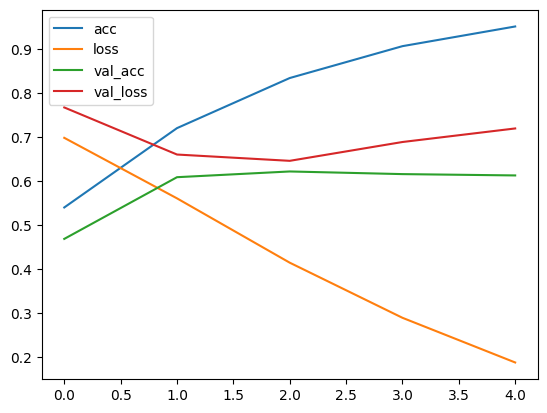

In [41]:
pd.DataFrame(pretrained_history.history).plot()

<ul>
    <li>Let's evaluate this last model on the test set.</li>
</ul>

In [42]:
test_loss, test_acc = pretrained_embedding_model.evaluate(test_X, test_y)
test_acc

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.6677 - loss: 0.6482


0.6549999713897705

<ul>
    <li>Still not as good as bag-of-words!</li>
</ul>